# 1. Глубокий анализ временных рядов

##Подготовка датасета

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import scipy
import plotly.graph_objects as go

drive.mount('/content/drive')

seoul_bikes = pd.read_csv('/content/drive/MyDrive/datasests/SeoulBikeData.csv', encoding = 'windows-1251')

seoul_bikes['Date'] = pd.to_datetime(seoul_bikes['Date'], format = '%d/%m/%Y')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(seoul_bikes.head())

        Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1     

## 1.1 Агрегация по периодам времени

### Группировка по месяцам, неделям, дате и дням недели

In [ ]:
rent_days = seoul_bikes.groupby(pd.Grouper(key = 'Date', freq = 'D'))['Rented Bike Count'].sum()
rent_weeks = seoul_bikes.groupby(pd.Grouper(key = 'Date', freq = 'W'))['Rented Bike Count'].sum()
rent_mounths = seoul_bikes.groupby(pd.Grouper(key = 'Date', freq = 'ME'))['Rented Bike Count'].sum()

### Средняя число прокатов по дням неделям

In [ ]:
names_days = ['W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-FRI', 'W-SAT', 'W-SUN']

rent_day_week = pd.DataFrame({
    'Day of the week': names_days,
    'Rented Bike Count': [seoul_bikes.groupby(pd.Grouper(key = 'Date', freq = i))['Rented Bike Count'].sum().mean() for i in names_days]
})

mean_count_rent_days = rent_day_week['Rented Bike Count']

print(mean_count_rent_days)

0    116458.754717
1    116458.754717
2    116458.754717
3    116458.754717
4    116458.754717
5    116458.754717
6    116458.754717
Name: Rented Bike Count, dtype: float64


In [ ]:
dates = pd.date_range(start='2023-01-01', periods=12, freq='ME')
month_names = dates.strftime('%B')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = month_names,
    y = rent_mounths, mode='lines'
))

fig.update_layout(
    title = 'Monthly trend',
    xaxis_title = 'Mounth',
    yaxis_title = 'Rented Bike Count'
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Bar(
    x = names_days,
    y = mean_count_rent_days,
))


fig.update_layout(
    title = 'Average count of rented bikes by day of the week',
    xaxis_title = 'Days of the week',
    yaxis_title = 'Rented Bike Count',
    template = 'plotly_white'
)

fig.show()

In [ ]:
seoul_bikes_working = seoul_bikes[seoul_bikes['Date'].dt.dayofweek.isin(range(5))]
seoul_bikes_holiday = seoul_bikes[seoul_bikes['Date'].dt.dayofweek.isin(range(5, 7))]

print(abs(seoul_bikes_working['Rented Bike Count'].mean() -
      seoul_bikes_holiday['Rented Bike Count'].mean()))

52.106766995775615


In [ ]:
rent_hours_working = seoul_bikes_working.groupby('Hour')['Rented Bike Count'].mean()
rent_hours_holiday= seoul_bikes_holiday.groupby('Hour')['Rented Bike Count'].mean()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = [i for i in range(24)],
    y = rent_hours_working,
    mode = 'lines'
))
fig.update_layout(
    title = 'Mean rent on working days',
    xaxis_title = 'Hours',
    yaxis_title = 'Rented Bike Count'
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = [i for i in range(24)],
    y = rent_hours_holiday,
    mode = 'lines'
))
fig.update_layout(
    title = 'Mean rent on holidays',
    xaxis_title = 'Hours',
    yaxis_title = 'Rented Bike Count'
)
fig.show()

### Вывод по графикам:
В будни наблюдаются пики в 8 и 18 часов, вероятнее всего время когда люди чаще всего едут на работу и возвращаются с неё. До 8 часов прокат невелик, как и после 18 часов. Между пиками прокат на достаточно высоком уровне.

В выходные дни график равномерно возврастает до достижения пика в 17 часов и далее равномерно убывает.

В среднем в будние дни активность более высокая, как и максимальная аренда в течении часа. Также активность в ночное время выше в выходные.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = [i for i in range(len(rent_days))],
    y = rent_days,
    mode = 'lines'
))
fig.update_layout(
    title = 'Rent by days',
    xaxis_title = 'Days',
    yaxis_title = 'Rented Bike Count'
)
fig.show()

In [ ]:
emissions = pd.DataFrame({
    'Date': [],
    'Rented Bike Count': []
})

for i in range(len(rent_days)):
    mean_rent = rent_days.iloc[max(0, i - 15): min(len(rent_days), i + 15)].mean()
    if mean_rent / rent_days.iloc[i] > 3:
        nw_row = pd.DataFrame({
            'Date': [seoul_bikes.iloc[i * 24, 0]],
            'Rented Bike Count': [rent_days.iloc[i]]
        })
        emissions = pd.concat([emissions, nw_row], ignore_index=True)

print(emissions)

         Date  Rented Bike Count
0  2018-04-05             2596.0
1  2018-04-11                0.0
2  2018-04-23              977.0
3  2018-05-10                0.0
4  2018-05-12             3034.0
5  2018-05-16             6416.0
6  2018-05-17             3521.0
7  2018-06-26             5200.0
8  2018-07-01             3231.0
9  2018-07-02             5240.0
10 2018-07-09             6191.0
11 2018-09-18                0.0
12 2018-09-19                0.0
13 2018-09-28                0.0
14 2018-09-30                0.0
15 2018-10-02                0.0
16 2018-10-04                0.0
17 2018-10-05             4522.0
18 2018-10-09                0.0
19 2018-11-03                0.0
20 2018-11-06                0.0
21 2018-11-08             1721.0
22 2018-11-09                0.0


<ipython-input-152-a8cfc3df817f>:13: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

<ipython-input-152-a8cfc3df817f>:8: RuntimeWarning:

divide by zero encountered in scalar divide



Корелляции с национальными праздниками Южной Кореи не обнаружены. Вероятно, причиной выбросов стали плохие погодные условия, технические неполадки сервиса или крупные мероприятия проводимые в Сеуле, которые не зафиксированы в открытых источниках.

In [ ]:
print(seoul_bikes[seoul_bikes['Holiday'] == 'Holiday'])

           Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
504  2017-12-22                196     0             -1.7           79   
505  2017-12-22                250     1             -1.6           79   
506  2017-12-22                161     2             -1.1           79   
507  2017-12-22                 99     3             -0.6           76   
508  2017-12-22                 64     4             -0.3           76   
...         ...                ...   ...              ...          ...   
7507 2018-10-09                  0    19             17.3           47   
7508 2018-10-09                  0    20             17.0           49   
7509 2018-10-09                  0    21             16.8           52   
7510 2018-10-09                  0    22             16.7           55   
7511 2018-10-09                  0    23             16.6           53   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
504                0.5               794

# 2. Обогащение и соединение данных

In [ ]:
name_holidays = pd.read_csv('/content/drive/MyDrive/datasests/south_korea_holidays.csv')
name_holidays['Date'] = pd.to_datetime(name_holidays['Date'], format = '%Y-%m-%d')

seoul_bikes = pd.merge(seoul_bikes, name_holidays, on = 'Date', how = 'outer')
seoul_bikes['Holiday'] = seoul_bikes['Name Holiday'].fillna('No')
seoul_bikes['Name Holiday'] = seoul_bikes['Name Holiday'].fillna('No')
seoul_bikes['Functioning Day'] = (seoul_bikes['Holiday'] == 'No').map({True: 'Yes', False: 'No'})

print(seoul_bikes)

           Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0    2017-12-01                254     0             -5.2           37   
1    2017-12-01                204     1             -5.5           38   
2    2017-12-01                173     2             -6.0           39   
3    2017-12-01                107     3             -6.2           40   
4    2017-12-01                 78     4             -6.0           36   
...         ...                ...   ...              ...          ...   
8755 2018-11-30               1003    19              4.2           34   
8756 2018-11-30                764    20              3.4           37   
8757 2018-11-30                694    21              2.6           39   
8758 2018-11-30                712    22              2.1           41   
8759 2018-11-30                584    23              1.9           43   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0                  2.2              2000

In [ ]:
print(seoul_bikes.isna().sum())

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Name Holiday                 0
dtype: int64


Нет пропущенных

# 3. Нестандартная аналитика и пользовательские метрики

In [ ]:
rentals = pd.read_csv('/content/drive/MyDrive/datasests/synthetic_rentals.csv')
stations = pd.read_csv('/content/drive/MyDrive/datasests/synthetic_stations.csv')
users = pd.read_csv('/content/drive/MyDrive/datasests/synthetic_users.csv')

In [ ]:
print(rentals.head())

  rental_id        date  hour  minute user_id station_id  duration_minutes
0   R000000  2017-01-01     0      45   U0010       S034                28
1   R000001  2017-01-01     0      17   U0824       S031                31
2   R000002  2017-01-01     0      38   U0954       S035                45
3   R000003  2017-01-01     0      41   U0047       S061                55
4   R000004  2017-01-01     0      25   U0908       S079                21


In [ ]:
print(users.head())

  user_id user_type registration_date       preferred_hours preferred_days  \
0   U0001  periodic        2022-10-22  10,11,12,13,14,15,16        weekday   
1   U0002      rare        2022-04-28                 7,8,9        weekday   
2   U0003      rare        2023-09-22                 7,8,9        weekend   
3   U0004  periodic        2023-07-22          7,8,17,18,19        weekend   
4   U0005  frequent        2023-06-08  7,8,9,12,13,17,18,19        weekday   

   avg_rentals_per_month  
0                      4  
1                      2  
2                      3  
3                      7  
4                     32  


In [ ]:
rare_users = users[users['user_type'] == 'rare']
pereodic_users = users[users['user_type'] == 'periodic']
frequent_users = users[users['user_type'] == 'frequent']

rare_users = pd.merge(
    left = rentals,
    right = rare_users,
    how = 'left',
    left_on = 'user_id',
    right_on = 'user_id'
).dropna()
pereodic_users = pd.merge(
    left = rentals,
    right = pereodic_users,
    how = 'left',
    left_on = 'user_id',
    right_on = 'user_id'
).dropna()
frequent_users = pd.merge(
    left = rentals,
    right = frequent_users,
    how = 'left',
    left_on = 'user_id',
    right_on = 'user_id'
).dropna()

rare_users['date'] = pd.to_datetime(rare_users['date'])
rare_users.set_index('date', inplace=True)

pereodic_users['date'] = pd.to_datetime(pereodic_users['date'])
pereodic_users.set_index('date', inplace=True)

frequent_users['date'] = pd.to_datetime(frequent_users['date'])
frequent_users.set_index('date', inplace=True)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = [i for i in range(24)],
    y = [len(rare_users[rare_users['hour'] == i]) for i in range(24)] ,
    mode = 'lines',
    name = 'Rare users'
))
fig.add_trace(go.Scatter(
    x = [i for i in range(24)],
    y = [len(pereodic_users[pereodic_users['hour'] == i]) for i in range(24)],
    mode = 'lines',
    name = 'Pereodic users'
))
fig.add_trace(go.Scatter(
    x = [i for i in range(24)],
    y = [len(frequent_users[frequent_users['hour'] == i]) for i in range(24)] ,
    mode = 'lines',
    name = 'Frequent users'
))
fig.update_layout(
    title = 'Count rent different categories users',
    xaxis_title = 'Hours',
    yaxis_title = 'Rented Bike Count'
)
fig.show()

Из графика вино что аренда переодических и редких пользователей слабо зависят от врмени, наибольшая активность с 9 до 16 часов, а пик в 21. Это может говорить о том, что эти пользователи берут в аренду велосипед в разных сценариях и в не рабочее время.

У регулярных пользователей напротив есть два выраженных пика c 7 до 9 и с 17 до 19. Вероятнее всего постоянные пользователи берут велосипеды в аренду чтобы добраться на работу и с неё, чем и обуславливается их постоянность.

In [ ]:
print('Rent and tempersture:', scipy.stats.pearsonr(seoul_bikes['Rented Bike Count'], seoul_bikes['Temperature(°C)'])[0])
print('Rent and humidity:', scipy.stats.pearsonr(seoul_bikes['Rented Bike Count'], seoul_bikes['Humidity(%)'])[0])
print('Rent and rainfall:', scipy.stats.pearsonr(seoul_bikes['Rented Bike Count'], seoul_bikes['Rainfall(mm)'])[0])

Rent and tempersture: 0.538558153013979
Rent and humidity: -0.19978016700089826
Rent and rainfall: -0.12307395980285012


Корреляция между арендой и температурой средняя, но присуствует, что говорить о том, что пользователи при низкой температуре реже берут велосепеды, но многи всё равно берут.

Корреляция с дождём и владожностью слишком мала, чтобы делать из этого выводы.



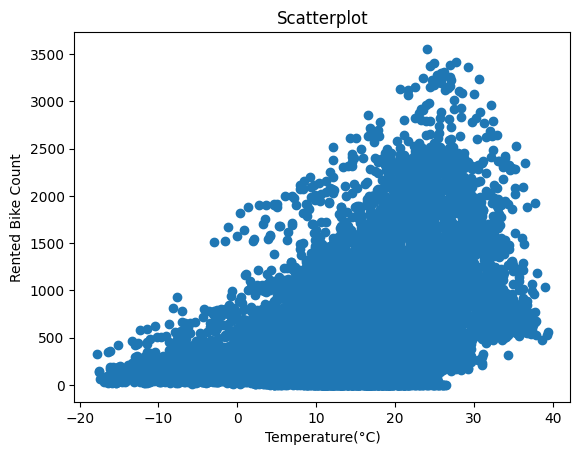

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(seoul_bikes['Temperature(°C)'], seoul_bikes['Rented Bike Count'])

# Настройка графика
plt.title('Scatterplot')
plt.xlabel('Temperature(°C)')
plt.ylabel('Rented Bike Count')

# Отображение графика
plt.show()

In [ ]:
print('Mean rent with rainfall:', seoul_bikes[seoul_bikes['Rainfall(mm)'] > 0]['Rented Bike Count'].mean())
print('Mean rent without rainfall:', seoul_bikes[seoul_bikes['Rainfall(mm)'] == 0]['Rented Bike Count'].mean())

Mean rent with rainfall: 163.4564393939394
Mean rent without rainfall: 739.3111030126337


In [ ]:
print('Low temperature:', seoul_bikes[seoul_bikes['Temperature(°C)'] < 0]['Rented Bike Count'].mean())
print('Middle temperature:', seoul_bikes[(seoul_bikes['Temperature(°C)'] >= 0) & (seoul_bikes['Temperature(°C)'] < 15)]['Rented Bike Count'].mean())
print('High temperature:', seoul_bikes[seoul_bikes['Temperature(°C)'] > 20]['Rented Bike Count'].mean())

Low temperature: 197.99092812281927
Middle temperature: 506.4689460476788
High temperature: 1117.5922731976543


Иcходя из проведённого анализа наибольшее влияние оказывает температура. Она показала наибольшию кореляцию и наибольший темп роста при увелечении температуры.

Менее значительно сказывается дождь, показывая небольшой коэфицент кореляции, но достаточно большие различия при сравнивании среднего проката с дождём и без него.

Влажность оказывает крайне малое влияние, в приделах погрешности.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(seoul_bikes.drop(['Date', 'Seasons', 'Rented Bike Count', 'Name Holiday'], axis = 1), seoul_bikes['Rented Bike Count'], test_size=0.2, random_state=42)

X_train['Holiday'] = X_train['Holiday'].apply(lambda x: 0 if x == 'No' else 1)
X_train['Functioning Day'] = X_train['Functioning Day'].map({'Yes': 1, 'No': 0})

X_test['Holiday'] = X_test['Holiday'].apply(lambda x: 0 if x == 'No' else 1)
X_test['Functioning Day'] = X_test['Functioning Day'].map({'Yes': 1, 'No': 0})

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred))

223368.69932591807


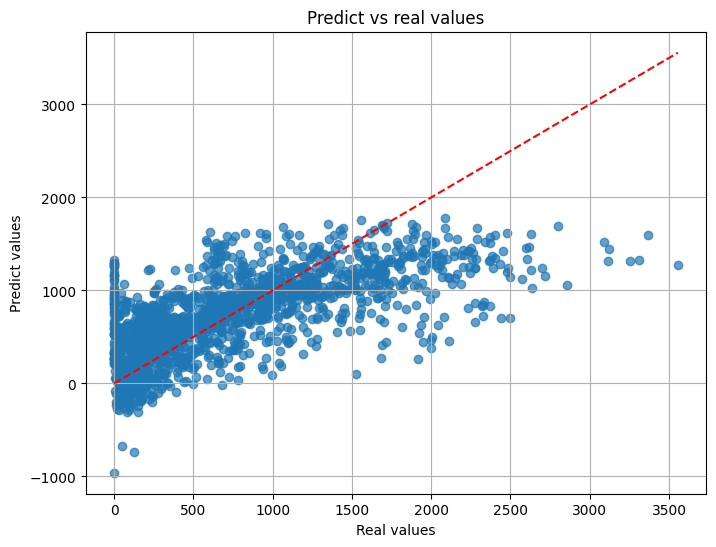

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Линия y = x
plt.xlabel("Real values")
plt.ylabel("Predict values")
plt.title("Predict vs real values")
plt.grid(True)
plt.show()

<ipython-input-167-05fdc11cb121>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




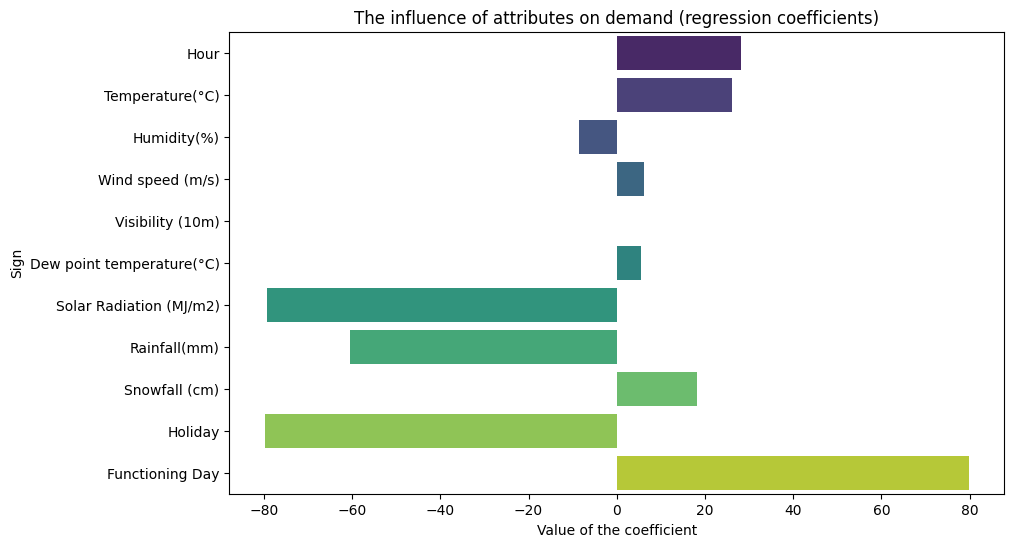

In [ ]:
import seaborn as sns

features = X_train.columns
coefs = model.coef_

plt.figure(figsize=(10, 6))
sns.barplot(x=coefs, y=features, palette='viridis')
plt.title('The influence of attributes on demand (regression coefficients)')
plt.xlabel('Value of the coefficient')
plt.ylabel('Sign')
plt.show()


In [ ]:
def generate_report(data, period):

    data = data.copy()
    data.set_index('Date', inplace=True)

    if period == 'day':
        resampled_data = data['Rented Bike Count'].resample('D').sum()
        title = 'Bike rental trend by day'
    elif period == 'week':
        resampled_data = data['Rented Bike Count'].resample('W').sum()
        title = 'Bike rental trend by week'
    elif period == 'month':
        resampled_data = data['Rented Bike Count'].resample('ME').sum()
        title = 'Bike rental trend by mount'

    print(f"Total number of rented bicycles for the period {period}: ",resampled_data.sum())
    print(f"Average number of rented bicycles per period {period}: ",resampled_data.mean())
    print(f"Maximum number of rented bikes per period {period}: ",resampled_data.max())
    print(f"Minimum number of rented bikes per period {period}: ",resampled_data.min())

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x = resampled_data.index,
        y = resampled_data,
        mode = 'lines'
    ))
    fig.update_layout(
        title = title,
        xaxis_title = 'Date',
        yaxis_title = 'Rented Bike Count'
    )
    fig.show()

generate_report(seoul_bikes, 'day')
generate_report(seoul_bikes, 'week')
generate_report(seoul_bikes, 'month')

Total number of rented bicycles for the period day:  6172314
Average number of rented bicycles per period day:  16910.449315068494
Maximum number of rented bikes per period day:  36149
Minimum number of rented bikes per period day:  0


Total number of rented bicycles for the period week:  6172314
Average number of rented bicycles per period week:  116458.75471698113
Maximum number of rented bikes per period week:  225206
Minimum number of rented bikes per period week:  23203


Total number of rented bicycles for the period month:  6172314
Average number of rented bicycles per period month:  514359.5
Maximum number of rented bikes per period month:  896887
Minimum number of rented bikes per period month:  150006


In [ ]:
seoul_bikes['Date'] = pd.to_datetime(seoul_bikes['Date'])
seoul_bikes['Month'] = seoul_bikes['Date'].dt.to_period('M')
seoul_bikes['weekday'] = seoul_bikes['Date'].dt.weekday

pivot = pd.pivot_table(
    seoul_bikes,
    values='Rented Bike Count',
    index='Month',
    columns='weekday',
    aggfunc='mean'
)

print(pivot)

weekday            0            1            2            3            4  \
Month                                                                      
2017-12   220.447917   247.312500   235.489583   284.114583   330.133333   
2018-01   207.716667   216.600000   199.575000   207.979167   223.760417   
2018-02   266.625000   282.000000   237.281250   231.104167   214.708333   
2018-03   458.208333   564.489583   573.218750   421.058333   580.183333   
2018-04   752.533333   834.260417   707.812500   715.885417   866.812500   
2018-05  1231.135417   998.933333   840.041667   708.416667  1025.656250   
2018-06  1232.625000  1130.385417  1365.010417  1167.583333  1374.158333   
2018-07   723.658333  1049.175000  1143.020833  1149.427083  1184.770833   
2018-08   867.291667   852.781250   820.108333   871.525000   941.016667   
2018-09   928.458333   880.968750   947.302083  1082.291667   800.479167   
2018-10  1078.508333   578.158333  1076.866667   815.500000   745.552083   
2018-11   83

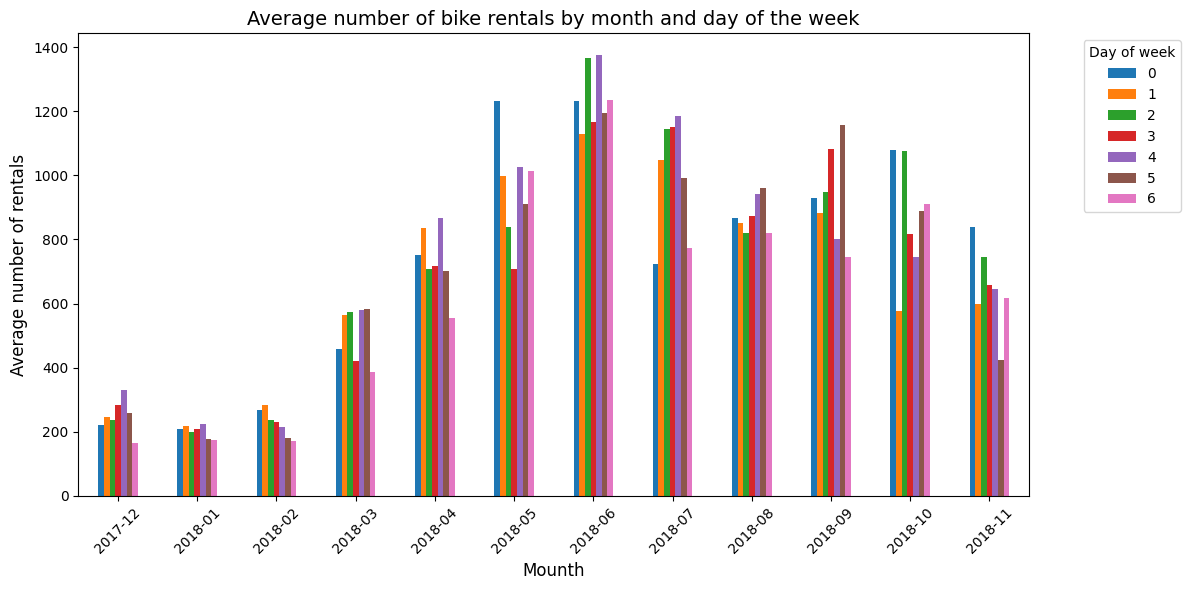

In [ ]:
pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Average number of bike rentals by month and day of the week', fontsize=14)
plt.xlabel('Mounth', fontsize=12)
plt.ylabel('Average number of rentals', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Day of week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
def get_time_category(hour):
    if 6 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 18:
        return 'День'
    elif 18 <= hour < 24:
        return 'Вечер'
    else:
        return 'Ночь'

seoul_bikes['TimeCategory'] = seoul_bikes['Hour'].apply(get_time_category)

pivot_weather = pd.pivot_table(
    seoul_bikes,
    values='Rented Bike Count',
    index=['Rainfall(mm)'],
    columns='TimeCategory',
    aggfunc='sum'
)

pivot_weather = pivot_weather.fillna(0)
pivot_weather = np.log1p(pivot_weather)

print(pivot_weather)

TimeCategory      Вечер       День       Ночь       Утро
Rainfall(mm)                                            
0.0           14.650294  14.423961  13.340716  14.094734
0.1            8.459776   7.979339   8.201386   8.267706
0.2            4.174387   6.583409   7.363914   7.203406
0.3            5.521461   0.000000   5.609472   6.781058
0.4            5.509388   6.986566   5.805135   6.194405
...                 ...        ...        ...        ...
21.0           2.995732   0.000000   0.000000   0.000000
21.5           6.391917   0.000000   0.000000   0.000000
24.0           4.127134   0.000000   0.000000   0.000000
29.5           4.812184   0.000000   0.000000   0.000000
35.0           0.000000   5.023881   0.000000   0.000000

[61 rows x 4 columns]


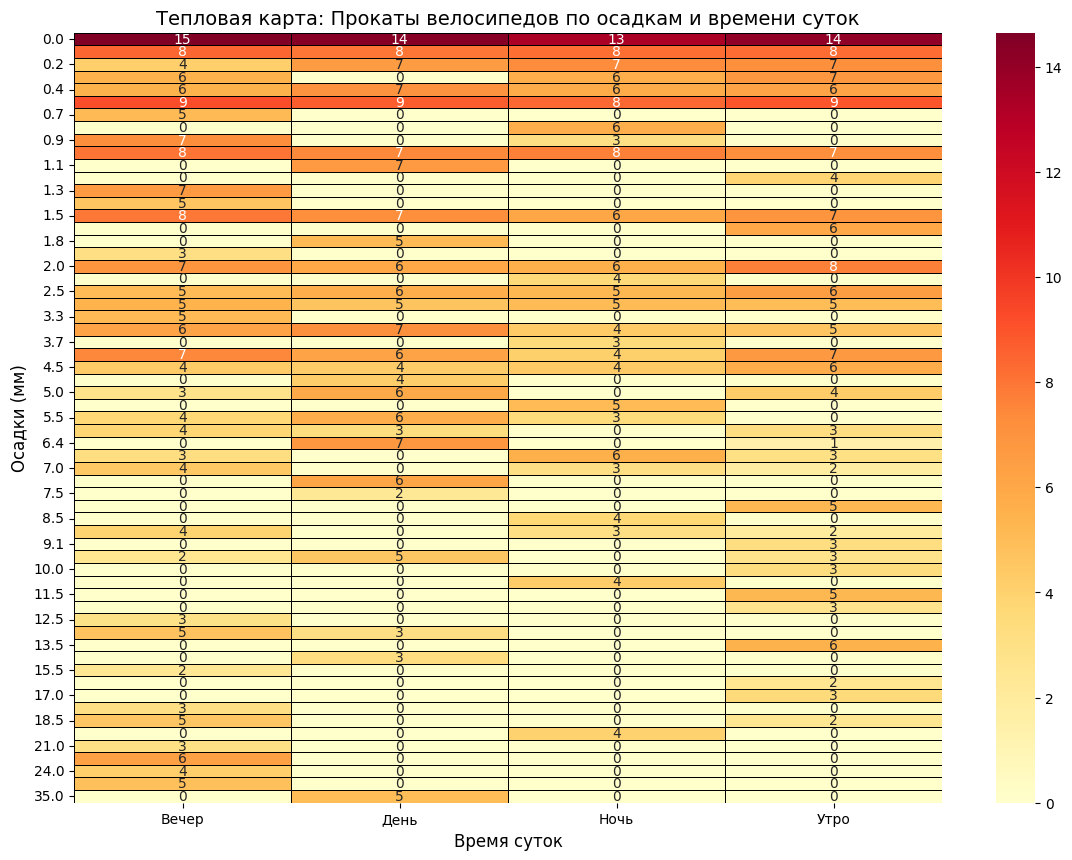

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    pivot_weather,
    annot=True,
    fmt=".0f",
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='black'
)

plt.title('Тепловая карта: Прокаты велосипедов по осадкам и времени суток', fontsize=14)
plt.xlabel('Время суток', fontsize=12)
plt.ylabel('Осадки (мм)', fontsize=12)
plt.show()

#5. Итоговый отчёт

По итогам проведённого анализа можно сделать некоторые выводы:


1.   Пик спроса по месяцам достигается в Июле после постпенно падает находясь в минимуме в зимнее месяцы, после февраля начинается рост.
2.   Средняя аренда в будние и выходные дни слабо отличется, но количество аренд в разные часы различны. В выходные дни график роста аренды показывает плавный рост и достигает пика к 17 часам, после чего плавно убывает. В будние дни наблюдаются два выраженных пика в 8 и 18 часов, что свидетельствует о том, что пользователи чаще всего используют велосипеды в будние дни для того чтобы добраться на работу и с неё.
3.    Из погодных условий сильнее всего сказывается температура, чуть меньше ветер и дождь.
4.    Были обнаруженны множественные выбросы как правило вниз. Совпадений с праздниками или иными городсикми мероприятиями выялено не было.
5.    Пользователей можно разделить на три категории по среднему количеству аренд в месяц. Шаблон использования велоспиедов у этих категорий различен. Редкие и переодические клиенты используют их в не предсказуемое время в течении дня, а постоянные напротив используют велоипеды чаще всего как транспорт на работу и с неё, о чём говорят выраженные пики аренды.




In [ ]:
!pip install dash plotly

In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

app = dash.Dash(__name__)

date_range = pd.date_range(start=seoul_bikes.iloc[0, 0], end=seoul_bikes.iloc[-1, 0], freq="D")
values = range(len(date_range))
df = pd.DataFrame({"Date": date_range, "Value": rent_days})

app = dash.Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Label("Выберите диапазон дат:"),
        dcc.DatePickerRange(
            id='date-picker-range',
            min_date_allowed=df['Date'].min(),
            max_date_allowed=df['Date'].max(),
            start_date=df['Date'].min(),
            end_date=df['Date'].max(),
            display_format='YYYY-MM-DD'
        )
    ], style={'margin-bottom': '20px'}),

    dcc.Graph(id='time-series-plot'),

    html.Div([
        html.Label("Выберите фактор:"),
        dcc.Dropdown(
            id='factor-dropdown',
            options=[
                {'label': 'Температура', 'value': 'Temperature(°C)'},
                {'label': 'Осадки', 'value': 'Rainfall(mm)'}
            ],
            value='Temperature(°C)'
        ),
        dcc.Graph(id='factor-plot')
    ])
])

@app.callback(
    Output('time-series-plot', 'figure'),
    [Input('date-picker-range', 'start_date'),
     Input('date-picker-range', 'end_date')]
)
def update_graph(start_date, end_date):
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    fig = px.line(filtered_df, x='Date', y='Value', title="График с выбором временного промежутка")
    return fig

@app.callback(
    Output('factor-plot', 'figure'),
    [Input('factor-dropdown', 'value')]
)
def update_factor_plot(selected_factor):
    fig = px.scatter(seoul_bikes, x=selected_factor, y='Rented Bike Count',
                     title=f'Зависимость прокатов велосипедов от {selected_factor}')
    return fig

if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>